In [57]:
import pandas as pd
import glob

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt

In [58]:
dtypes = {
    "year": int,
    "country": str,
    "doc_number": str  # Treat doc_number as a string initially to avoid mixed type issues
}

# Load CSV files with specified dtypes
csv_files = glob.glob("../../../raw_data/scrape_data/foster_patents/collected_patents_without_full_data/patents_foster_*.csv")
dfs = [pd.read_csv(file, dtype=dtypes) for file in csv_files]
df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all[(df_all["year"] <= 1928) | (df_all["year"] == 2020)]

print(f"Loaded {len(df_all)} rows from {len(csv_files)} files.")
df_all = df_all[df_all["doc_number"].astype(str).str.isdigit()]


Loaded 3661892 rows from 10 files.


In [59]:
#Count patents per year from your collected data
yearly_counts = df_all['year'].value_counts().sort_index()

# Create a full range of years
full_years = pd.DataFrame({'year': range(1700, 2025)})

# Merge the counts with the full year range
df_year_summary = full_years.merge(
    yearly_counts.rename('patents_collected'), 
    how='left', 
    left_on='year', 
    right_index=True
)

df_year_summary['patents_collected'] = df_year_summary.apply(
    lambda row: 0 if row['year'] <= 1928 and pd.isna(row['patents_collected']) else row['patents_collected'],
    axis=1
)

df_year_summary['is_actual'] = df_year_summary.apply(
    lambda row: True if row['year'] <= 1928 or pd.notna(row['patents_collected']) else False,
    axis=1
)

df_year_summary['patents_predicted'] = pd.NA
display(df_year_summary)


,year,patents_collected,is_actual,patents_predicted
0,1700,0.0,True,<NA>
1,1701,0.0,True,<NA>
2,1702,0.0,True,<NA>
3,1703,0.0,True,<NA>
4,1704,0.0,True,<NA>
...,...,...,...,...
320,2020,205411.0,True,<NA>
321,2021,NaN,False,<NA>
322,2022,NaN,False,<NA>
323,2023,NaN,False,<NA>


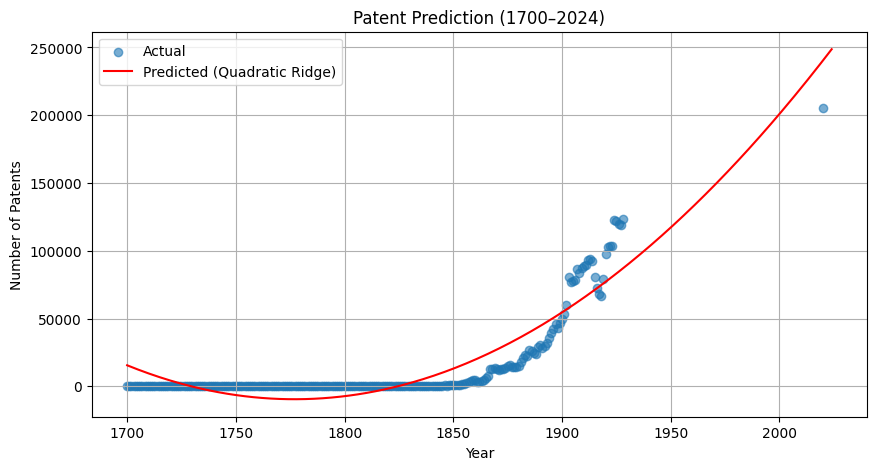

In [60]:
# 1. Prepare training data (only actual collected patent data)
train_data = df_year_summary[df_year_summary['is_actual'] == True].copy()

X_train_raw = train_data['year'].values.reshape(-1, 1)
y_train = train_data['patents_collected'].values

# 2. Normalize years (subtract mean for numerical stability)
year_mean = X_train_raw.mean()
X_train = X_train_raw - year_mean

# 3. Create polynomial features (try degree=2 or 3)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)

# 4. Train Ridge Regression model (better than LinearRegression for noisy data)
model = RidgeCV(alphas=[0.1, 1.0, 10.0])
model.fit(X_poly, y_train)

# 5. Predict for all years (1700–2024)
all_years_raw = df_year_summary['year'].values.reshape(-1, 1)
all_years = all_years_raw - year_mean  # normalize the same way
X_all_poly = poly.transform(all_years)

df_year_summary['patents_predicted'] = model.predict(X_all_poly)

# 6. Update predictions only for missing values
missing_mask = df_year_summary['is_actual'] == False
missing_years = df_year_summary.loc[missing_mask, 'year'].values.reshape(-1, 1)
missing_years_scaled = missing_years - year_mean
df_year_summary.loc[missing_mask, 'patents_predicted'] = model.predict(poly.transform(missing_years_scaled))

# 7. Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.scatter(df_year_summary['year'], df_year_summary['patents_collected'], label='Actual', alpha=0.6)
plt.plot(df_year_summary['year'], df_year_summary['patents_predicted'], label='Predicted (Quadratic Ridge)', color='red')
plt.xlabel("Year")
plt.ylabel("Number of Patents")
plt.title("Patent Prediction (1700–2024)")
plt.legend()
plt.grid(True)
plt.show()

In [62]:
display(df_year_summary)


,year,patents_collected,is_actual,patents_predicted
0,1700,0.0,True,15507.027920
1,1701,0.0,True,14860.309558
2,1702,0.0,True,14222.051359
3,1703,0.0,True,13592.253323
4,1704,0.0,True,12970.915451
...,...,...,...,...
320,2020,205411.0,True,240363.883541
321,2021,NaN,False,242424.417414
322,2022,NaN,False,244493.411450
323,2023,NaN,False,246570.865650


In [64]:
# Total number of patents to sample from: actual + predicted
df_year_summary['patents_total'] = df_year_summary.apply(
    lambda row: row['patents_collected'] if row['is_actual'] 
                else row.get('patents_predicted', 0),
    axis=1
)
actual_patents = df_year_summary['patents_collected'].sum()
total_patents = df_year_summary['patents_total'].sum()

display(df_year_summary.tail(10))
print(f"total number of actaul patents: {actual_patents}")
print(f"Total number of patents to sample from: {total_patents}")
print(f"Percentage of patents collected: {actual_patents / total_patents * 100:.2f}%")

,year,patents_collected,is_actual,patents_predicted,patents_total
315,2015,NaN,False,230188.116624,230188.116624
316,2016,NaN,False,232206.349681,232206.349681
317,2017,NaN,False,234233.042901,234233.042901
318,2018,NaN,False,236268.196284,236268.196284
319,2019,NaN,False,238311.809831,238311.809831
320,2020,205411.0,True,240363.883541,205411.000000
321,2021,NaN,False,242424.417414,242424.417414
322,2022,NaN,False,244493.411450,244493.411450
323,2023,NaN,False,246570.865650,246570.865650
324,2024,NaN,False,248656.780013,248656.780013


total number of actaul patents: 3620061.0
Total number of patents to sample from: 18947766.62623035
Percentage of patents collected: 19.11%


In [66]:
sample_rate = 0.01  # 1% base sample rate
df_year_summary['sample_amount'] = df_year_summary['patents_total'].apply(
    lambda total: int(total) if total < 100 else max(100, int(np.ceil(total * sample_rate)))
)
display(df_year_summary.iloc[225:235])
#display(df_year_summary.head(10))
print(f"Total amount of samples: {df_year_summary['sample_amount'].sum()}")
print(f"samples not collected: {df_year_summary.loc[df_year_summary['is_actual'] == False, 'sample_amount'].sum()}")

,year,patents_collected,is_actual,patents_predicted,patents_total,sample_amount
225,1925,121985.0,True,83191.509947,121985.000000,1220
226,1926,119905.0,True,84448.328313,119905.000000,1200
227,1927,119003.0,True,85713.606842,119003.000000,1191
228,1928,123749.0,True,86987.345534,123749.000000,1238
229,1929,NaN,False,88269.544390,88269.544390,883
230,1930,NaN,False,89560.203408,89560.203408,896
231,1931,NaN,False,90859.322590,90859.322590,909
232,1932,NaN,False,92166.901936,92166.901936,922
233,1933,NaN,False,93482.941444,93482.941444,935
234,1934,NaN,False,94807.441116,94807.441116,949


Total amount of samples: 192130
samples not collected: 153322


In [67]:
uncollected_rows = df_year_summary[df_year_summary['is_actual'] == False]

uncollected_years_amount = uncollected_rows[['year', 'sample_amount']]


In [21]:
sampled_dfs = []  # Collect sampled data here

for _, row in df_year_summary[df_year_summary['is_actual']].iterrows():
    year = row['year']
    n_samples = int(row['sample_amount'])

    # Filter df_all for the current year
    year_patents = df_all[df_all['year'] == year]

    # If there are fewer patents than we want to sample (edge case protection)
    n_samples = min(n_samples, len(year_patents))

    # Sample randomly without replacement
    if n_samples > 0:
        sampled = year_patents.sample(n=n_samples, replace=False, random_state=42)
        sampled_dfs.append(sampled)

# Combine all samples into a single DataFrame
sampled_df = pd.concat(sampled_dfs, ignore_index=True)

# Save the sampled data to a CSV file
sampled_df.to_csv('sampled_patents.csv', index=False)